In [ ]:
#for d2l
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install d2l==1.0.0b0

<h2>Multilayer_Perceptrons</h2>

<h3>5.1. Multilayer Perceptrons</h3>


*   Hidden layer -> Using ReLU as Activation function
*   항목 추가




In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

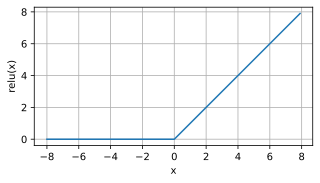

In [2]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

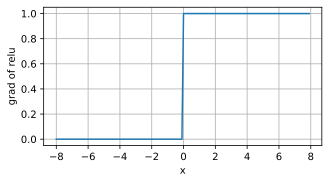

In [4]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

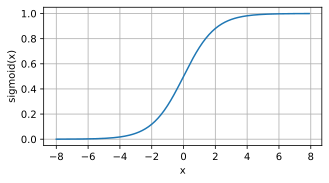

In [5]:
#Sigmoid > Gradient vanishing...
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

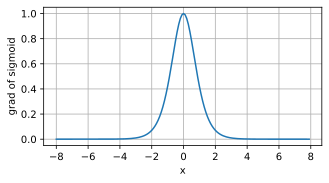

In [9]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

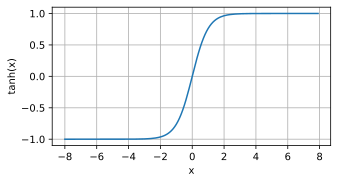

In [7]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

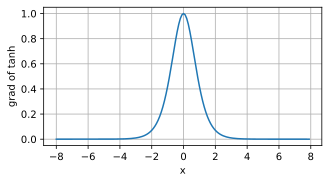

In [8]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

<h3>5.2. Implementation of Multilayer Perceptrons</h3>


*   gd
*   ㅎㅇ


In [10]:
import torch
from torch import nn
from d2l import torch as d2l

In [11]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

In [12]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [13]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

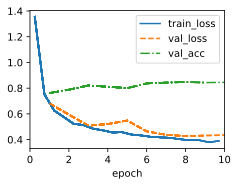

In [14]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [15]:
#Concise
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

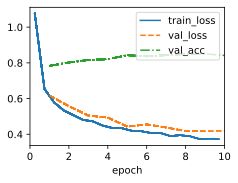

In [16]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

<h3>5.3. Forward Propagation, Backward Propagation, and Computational Graphs</h3>


*   Forward propagation sequentially calculates and stores intermediate variables within the computational graph defined by the neural network. It proceeds from the input to the output layer.
*   Backpropagation sequentially calculates and stores the gradients of intermediate variables and parameters within the neural network in the reversed order.
*   When training deep learning models, forward propagation and backpropagation are interdependent, and training requires significantly more memory than prediction.



<h3>5.4. Numerical Stability and Initialization</h3>



*   Vanishing Gradients -> Wrong choice of activation function (e.g., sigmoid)
*   Exploding Gradients
<hr>
*<b>(Careful) Parameter initialization</b> mitigates it.
  - Default Initialization
  - Xavier Initialization



In [17]:
%matplotlib inline
import torch
from d2l import torch as d2l

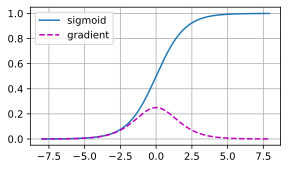

In [18]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [19]:
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n',M)
for i in range(100):
    M = M @ torch.normal(0, 1, size=(4, 4))
print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[ 0.7833,  0.6996, -1.0371,  0.0981],
        [ 0.5968,  1.0540,  1.6049, -1.6624],
        [-2.7382, -2.5967, -1.0413,  0.3659],
        [-0.9072,  0.3195,  1.2661,  0.7427]])
after multiplying 100 matrices
 tensor([[-1.0379e+20,  2.5672e+20,  9.6773e+20,  2.0552e+20],
        [-4.7681e+21,  1.1676e+22,  4.3692e+22,  9.3125e+21],
        [ 1.2771e+21, -3.1291e+21, -1.1713e+22, -2.4961e+21],
        [ 2.6650e+21, -6.5315e+21, -2.4456e+22, -5.2109e+21]])


<h3>5.5. Generalization in Deep Learning</h3>


*   Early stopping



<h3>5.6. Dropout</h3>


*   training with input noise is equivalent to Tikhonov regularization. -> apply this idea to the internal layers of a network = dropout
*  One of the Regularization way to prevent overfitting


In [21]:
import torch
from torch import nn
from d2l import torch as d2l

In [22]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [23]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  0.,  4.,  0.,  0., 10., 12.,  0.],
        [16.,  0., 20., 22.,  0., 26., 28.,  0.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [24]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

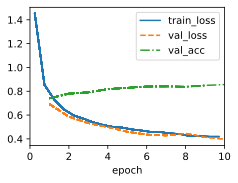

In [25]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [26]:
#Concise Way
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

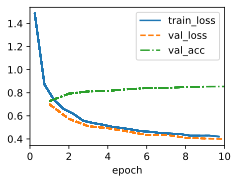

In [27]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)

<h3>5.7. Predicting House Prices on Kaggle</h3>

In [28]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [29]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [31]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [32]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [33]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [34]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [35]:
data.preprocess()
data.train.shape

(1460, 332)

In [36]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [37]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [38]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functi

average validation log mse = 0.1785288938879967


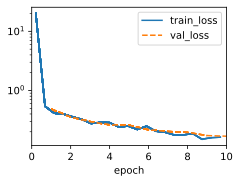

In [39]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [40]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)